# A Practical Guide to Activation Threshold Search in Post-Training Quantization

[Run this tutorial in Google Colab](https://colab.research.google.com/github/sony/model_optimization/blob/main/tutorials/notebooks/mct_features_notebooks/pytorch/example_pytorch_activation_threshold_search.ipynb)

## Overview
This tutorial demonstrates how to find the optimal activation threshold, a key component in MCT's post-training quantization workflow.

In this example, we will explore two different metrics for threshold selection. We will begin by applying the appropriate MCT configurations, followed by inferring a representative dataset through the model. Next, we will plot the activation distributions of two layers along with their corresponding MCT-calculated thresholds, and finally, we will compare the quantized model accuracy using both methods.

## Activation threshold explanation
During the quantization process, thresholds are used to map a distribution of 32-bit floating-point values to their quantized equivalents. Minimizing data loss while preserving the most representative range is crucial for maintaining the final model's accuracy.

### How Is It Done in MCT?

MCT's post-training quantization leverages a representative dataset to evaluate a range of typical output activation values. The challenge lies in determining the best way to map these values to their quantized versions. To address this, a grid search is performed to find the optimal threshold using various error metrics. Typically, mean squared error (MSE) is the most effective and is used as the default metric.

The error is calculated based on the difference between the original float and the quantized distributions. The optimal threshold is then selected based on the metric that results in the minimum error. For example, for the case of MSE.

$$
ERR(t) = \frac{1}{n_s} \sum_{X \in Fl(D)} (Q(X, t, n_b) - X)^2
$$

- $ERR(t)$ : The quantization error function dependent on the threshold $t$.

- $n_s$: The size of the representative dataset.

- $\sum$: Summation over all elements $X$ in the flattened dataset $F_l(D)$.

- $F_l(D)$: The set of activation tensors in the $l$-th layer, flattened for processing.

- $Q(X, t, n_b)$: The quantized approximation of $X$, given a threshold $t$ and bit width $n_b$.

- $X$: The original activation tensor before quantization.

- $t$: The quantization threshold, a key parameter for controlling the quantization process.

- $n_b$: The number of bits used in quantization, impacting model precision and size.


Quantization thresholds often have specific limitations, typically imposed for deployment purposes. In MCT, activation thresholds are restricted by default to Power-of-Two values and can represent either signed values within the range $(-T, T)$ or unsigned values within $(0, T)$. Other restriction settings are also configurable.

### Error methods supported by MCT:

- **NOCLIPPING:** Use min/max values as thresholds.

- **MSE:** Minimizes quantization noise by using the mean squared error (MSE).

- **MAE:** Minimizes quantization noise by using the mean absolute error (MAE).

- **KL:** Uses Kullback-Leibler (KL) divergence to align the distributions, ensuring that the quantized distribution is as similar as possible to the original.

- **Lp:** Minimizes quantization noise using the Lp norm, where `p` is a configurable parameter that determines the type of distance metric.

## Setup
Install the relevant packages:

In [1]:
!pip install -q torch torchvision


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import importlib
if not importlib.util.find_spec('model_compression_toolkit'):
    !pip install model_compression_toolkit

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.datasets import ImageNet

Load a pre-trained MobileNetV2 model from pytorch, in 32-bits floating-point precision format.

In [4]:
weights = MobileNet_V2_Weights.IMAGENET1K_V2

float_model = mobilenet_v2(weights=weights)

## Dataset preparation
### Download the ImageNet validation set
Download the ImageNet dataset with only the validation split.
**Note:** For demonstration purposes we use the validation set for the model quantization routines. Usually, a subset of the training dataset is used, but loading it is a heavy procedure that is unnecessary for the sake of this demonstration.

This step may take several minutes...

In [5]:
import os
 
if not os.path.isdir('imagenet'):
    !mkdir imagenet
    !wget -P imagenet https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz
    !wget -P imagenet https://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar

Extract ImageNet validation dataset using torchvision "datasets" module.

In [6]:
dataset = ImageNet(root='./imagenet', split='val', transform=weights.transforms())

## Representative Dataset
For quantization with MCT, we need to define a representative dataset required by the PTQ algorithm. This dataset is a generator that returns a list of images:

In [7]:
batch_size = 8
n_iter = 10

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def representative_dataset_gen():
    dataloader_iter = iter(dataloader)
    for _ in range(n_iter):
        yield [next(dataloader_iter)[0]]

## Target Platform Capabilities
MCT optimizes the model for dedicated hardware. This is done using TPC (for more details, please visit our [documentation](https://sony.github.io/model_optimization/api/api_docs/modules/target_platform.html)). Here, we use the default Tensorflow TPC:

In [8]:
import model_compression_toolkit as mct

# Get a TargetPlatformCapabilities object that models the hardware platform for the quantized model inference. Here, for example, we use the default platform that is attached to a Pytorch layers representation.
target_platform_cap = mct.get_target_platform_capabilities('pytorch', 'default')

## Post-Training Quantization using MCT
In this step, we load the model and apply post-training quantization using two threshold error calculation methods: **"No Clipping"** and **MSE**.

- **"No Clipping"** selects the lowest power-of-two threshold that ensures no data is lost (clipped).
- **MSE** selects a power-of-two threshold that minimizes the mean square error between the original float distribution and the quantized distribution.

- As a result, the "No Clipping" method typically results in a larger threshold, as we will demonstrate later in this tutorial.

The quantization parameters are predefined, and we use the default values except for the quantization method. Feel free to modify the code below to experiment with other error metrics supported by MCT.

In [9]:
from model_compression_toolkit.core import QuantizationErrorMethod

q_configs_dict = {}
# Error methods to iterate over
error_methods = [
    QuantizationErrorMethod.MSE,
    QuantizationErrorMethod.NOCLIPPING
]

# If you are curious you can add any of the below quantization methods as well.
# QuantizationErrorMethod.MAE
# QuantizationErrorMethod.KL
# QuantizationErrorMethod.LP

# Iterate and build the QuantizationConfig objects
for error_method in error_methods:
    q_config = mct.core.QuantizationConfig(
        activation_error_method=error_method,
    )

    q_configs_dict[error_method] = q_config

Now we will run post-training quantization for each configuration:

In [10]:
quantized_models_dict = {}

for error_method, q_config in q_configs_dict.items():
    # Create a CoreConfig object with the current quantization configuration
    ptq_config = mct.core.CoreConfig(quantization_config=q_config)

    # Perform MCT post-training quantization
    quantized_model, quantization_info = mct.ptq.pytorch_post_training_quantization(
        in_module=float_model,
        representative_data_gen=representative_dataset_gen,
        core_config=ptq_config,
        target_platform_capabilities=target_platform_cap
    )

    # Update the dictionary to include the quantized model
    quantized_models_dict[error_method] = {
        "quantization_config": q_config,
        "quantized_model": quantized_model,
        "quantization_info": quantization_info
    }


Statistics Collection: 10it [00:10,  1.00s/it]
Calculating quantization parameters: 100%|██████████| 102/102 [00:17<00:00,  5.98it/s]
Statistics Collection: 10it [00:10,  1.00s/it]
Calculating quantization parameters: 100%|██████████| 102/102 [00:17<00:00,  5.99it/s]


## Threshold and Distribution Visualization
To facilitate understanding, we will plot the activation distributions for two layers of MobileNetV2. For each layer, we will show the thresholds determined by both **MSE** and **No Clipping** methods, along with the corresponding activation distributions obtained by infering the representative dataset through the model. This visualization highlights the trade-off between data loss and data resolution under different thresholds during quantization.

MCT’s `quantization_info` stores the threshold values for each layer. However, to view the actual activation distributions, the model needs to be reconstructed up to and including the target layer selected for visualization.

To do this, we first need to identify the layer names. 

In [11]:
import torch
import torch.nn as nn
def get_leaf_layer_info(module, parent_name=''):
    leaf_layer_info = []
    
    # Iterate through all child modules with their names
    for name, child in module.named_children():
        # Construct the full name of the child layer
        full_name = f"{parent_name}.{name}" if parent_name else name
        
        # Recurse into the child module
        leaf_layer_info.extend(get_leaf_layer_info(child, full_name))
    
    # If it has no children, it's a leaf layer; add its name and type
    if not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and not list(module.children()):
        leaf_layer_info.append((parent_name, type(module).__name__))

    return leaf_layer_info

print('---------------------------')
print(float_model)
print('---------------------------')

leaf_layer_info = get_leaf_layer_info(float_model)
for index, (name, layer) in enumerate(float_model.named_modules()):
    if index <= 1: continue
    if index < 15:
        print("#", index, name, layer)
    else:
        break

for index, (layer_name, layer_type) in enumerate(leaf_layer_info):
    #print(f"Layer Name: {layer_name}, Layer Type: {layer_type}")
    if index < 10:
        print(f"Name: {layer_name}, Type: {layer_type}")
    else:
        break

---------------------------
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

The first activation layer in the model is named `ReLU6`.

For this particular model, testing has shown that the `BatchNorm2d` layer exhibits different thresholds for the two error metrics. Therefore, we will also include this layer in the visualization. For context, MobileNetV2 uses an inverted residual structure, where the input is first expanded in the channel dimension, then passed through a depthwise convolution, and finally projected back to a lower dimension. The `BatchNorm2d` layer represents this projection, and the BN suffix indicates the presence of Batch Normalization.

We will use these layer names to create two separate models, each ending at one of these respective layers.

In [12]:
layer_name1 = 'features.0.2'          # Conv1_relu
layer_name2 = 'features.1.conv.1'     # expanded_conv_project_BN

# add hook
def get_layer_output(model, layer_name):
    outputs = {}

    def hook(module, input, output):
        outputs[layer_name] = output

    # add hook
    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(hook)

    return outputs

# get Conv1_relu's output
output_dict_relu = get_layer_output(float_model, layer_name1)

# get expanded_conv_project_BN's output（features.1.conv.1 is next to activation-layer）
output_dict_project = get_layer_output(float_model, layer_name2)


Infer the representative dataset using these models and store the outputs for further analysis.

In [13]:
from tqdm import tqdm
import numpy as np
activation_batches_relu = []
activation_batches_project = []
with torch.no_grad():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    float_model = float_model.to(device)
    for data in tqdm(representative_dataset_gen()):
        images = data[0]
        images = images.to(device)

        float_model(images)

        activations_relu = output_dict_relu[layer_name1]
        activation_batches_relu.append(activations_relu.to('cpu').detach().numpy().copy())
        activations_project = output_dict_project[layer_name2]
        activation_batches_project.append(activations_project.to('cpu').detach().numpy().copy())

    all_activations_relu = np.concatenate(activation_batches_relu, axis=0).flatten()
    all_activations_project = np.concatenate(activation_batches_project, axis=0).flatten()

10it [00:00, 13.84it/s]


Thresholds calculated by MCT during quantization can be accessed using the following approach. The layer indices correspond to the order of the layers listed in the previous steps.

As noted earlier, we focus on the first ReLU activation layer and the Batch Normalization layer (`expanded_conv_project_BN`) since they effectively illustrate the impact of the two threshold error methods.

In [14]:
# layer 4 is the first activation layer - Conv1_relu
optimal_thresholds_relu = {
    error_method: data["quantized_model"].features_0_2_activation_holder_quantizer.activation_holder_quantizer.threshold_np
    for error_method, data in quantized_models_dict.items()
}

print(optimal_thresholds_relu)

print(quantized_models_dict.items())

# layer 9 is the batch normalisation projection layer - Expanded_conv_project_BN
optimal_thresholds_project = {
    error_method: data["quantized_model"].features_1_conv_1_bn_activation_holder_quantizer.activation_holder_quantizer.threshold_np
    for error_method, data in quantized_models_dict.items()
}

print(optimal_thresholds_project)

{<QuantizationErrorMethod.MSE: 1>: np.float64(8.0), <QuantizationErrorMethod.NOCLIPPING: 0>: np.float64(8.0)}
dict_items([(<QuantizationErrorMethod.MSE: 1>, {'quantization_config': QuantizationConfig(activation_error_method=<QuantizationErrorMethod.MSE: 1>, weights_error_method=<QuantizationErrorMethod.MSE: 1>, relu_bound_to_power_of_2=False, weights_bias_correction=True, weights_second_moment_correction=False, input_scaling=False, softmax_shift=False, shift_negative_activation_correction=True, activation_channel_equalization=False, z_threshold=inf, min_threshold=1.52587890625e-05, l_p_value=2, linear_collapsing=True, residual_collapsing=True, shift_negative_ratio=0.05, shift_negative_threshold_recalculation=False, shift_negative_params_search=False, concat_threshold_update=False, activation_bias_correction=False, activation_bias_correction_threshold=0.0, custom_tpc_opset_to_layer=None), 'quantized_model': PytorchModel(
  (x): DummyPlaceHolder()
  (x_activation_holder_quantizer): Pytor

### Distribution Plots
Below are the activation distributions for the two selected layers: first, the ReLU activation layer, `Conv1_relu`, followed by the `expanded_conv_project_BN` layer.

The second distribution clearly highlights the differences between the two error metrics, showing the impact of each on the resulting quantization threshold.

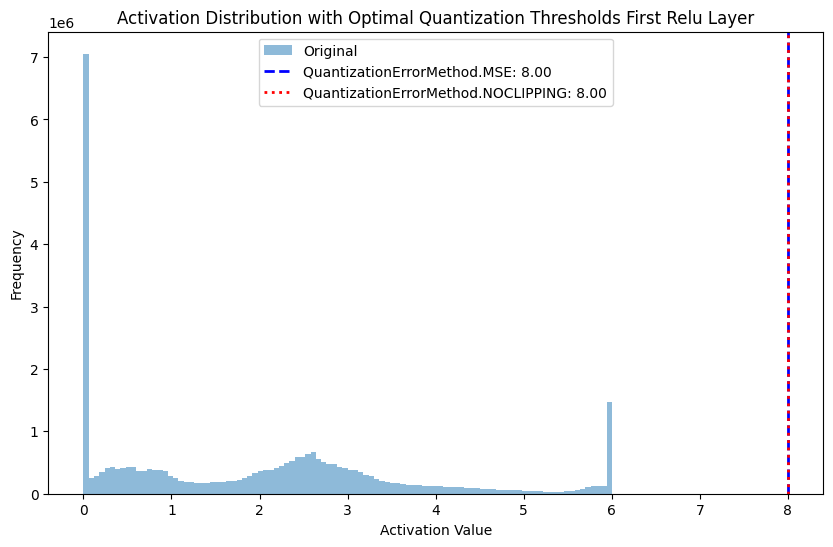

In [15]:
import matplotlib.pyplot as plt

ls_table = ['--', ':']
lc_table = ['blue', 'red']

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(all_activations_relu, bins=100, alpha=0.5, label='Original')
for index, (method, threshold) in enumerate(optimal_thresholds_relu.items()):
    plt.axvline(threshold, linestyle=ls_table[index], color=lc_table[index], linewidth=2, label=f'{method}: {threshold:.2f}')

plt.title('Activation Distribution with Optimal Quantization Thresholds First Relu Layer')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

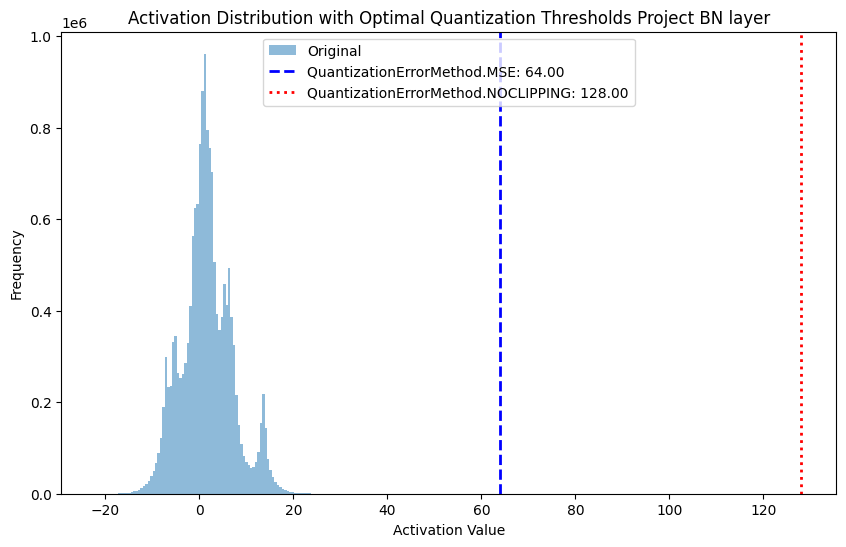

In [16]:
import matplotlib.pyplot as plt

ls_table = ['--', ':']
lc_table = ['blue', 'red']

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(all_activations_project, bins=100, alpha=0.5, label='Original')
for index, (method, threshold) in enumerate(optimal_thresholds_project.items()):
    plt.axvline(threshold, linestyle=ls_table[index], color=lc_table[index], linewidth=2, label=f'{method}: {threshold:.2f}')

plt.title('Activation Distribution with Optimal Quantization Thresholds Project BN layer')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Model Evaluation
Finally, we can demonstrate the impact of these different thresholds on the model's overall accuracy.
In order to evaluate our models, we first need to load the validation dataset.

In [17]:
from tqdm import tqdm
import torch.nn.functional as F

val_dataset = ImageNet(root='./imagenet', split='val', transform=weights.transforms())
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

def evaluate(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy * 100.0))
    
    return test_loss, accuracy 

_, float_accuracy = evaluate(float_model, val_loader)
print(f"Float model's Top 1 accuracy on the Imagenet validation set: {(float_accuracy * 100.0):.2f}%")


100%|██████████| 391/391 [05:47<00:00,  1.13it/s]


Test set: Average loss: -6.5173, Accuracy: 35494/50000 (71%)

Float model's Top 1 accuracy on the Imagenet validation set: 70.99%


In [18]:
evaluation_results = {}

for error_method, data in quantized_models_dict.items():
    quantized_model = data["quantized_model"]

    results = evaluate(quantized_model, val_loader)

    evaluation_results[error_method] = results

    # Print the results
    print(f"Results for {error_method}: Loss = {results[0]}, Accuracy = {results[1]}")


100%|██████████| 391/391 [03:47<00:00,  1.72it/s]



Test set: Average loss: -6.0622, Accuracy: 35966/50000 (72%)

Results for QuantizationErrorMethod.MSE: Loss = -6.06215625, Accuracy = 0.71932


100%|██████████| 391/391 [05:44<00:00,  1.14it/s]


Test set: Average loss: -6.2207, Accuracy: 35962/50000 (72%)

Results for QuantizationErrorMethod.NOCLIPPING: Loss = -6.2207425, Accuracy = 0.71924


These results are consistent across many models, which is why MSE is set as the default method.

Each of MCT's error methods impacts models differently, so it is recommended to include this metric as part of hyperparameter tuning when optimizing quantized model accuracy.


## Conclusion
In this tutorial, we explored the process of finding optimal activation thresholds using different error metrics in MCT’s post-training quantization workflow. By comparing the **MSE** and **No Clipping** methods, we demonstrated how the choice of threshold can significantly affect the activation distributions and, ultimately, the quantized model’s performance. While **MSE** is commonly the best choice and is used by default, it is essential to consider other error metrics during hyperparameter tuning to achieve the best results for different models.

Understanding the impact of these thresholds on data loss and resolution is critical when fine-tuning the quantization process for deployment, making this a valuable step in building high-performance quantized models.


## Appendix
Below is a code snippet that can be used to extract information from each layer in the MCT quantization output, assisting in analyzing the layer-wise quantization details.

In [19]:
import torch.nn as nn

def flatten_model(modules):
    def flatten_list(_2d_list):
        flat_list = []
        # Iterate through the outer list
        for element in _2d_list:
            if type(element) is list:
                # If the element is of type list, iterate through the sublist
                for item in element:
                    flat_list.append(item)
            else:
                flat_list.append(element)
        return flat_list

    ret = []
    try:
        for _, n in modules:
            ret.append(flatten_model(n))
    except:
        try:
            if str(modules._modules.items()) == "odict_items([])":
                ret.append(modules)
            else:
                for _, n in modules._modules.items():
                    ret.append(flatten_model(n))
        except:
            ret.append(modules)
    return flatten_list(ret)

quantized_model = data["quantized_model"]
quantizer_object = quantized_model.features_0_2_activation_holder_quantizer

quantized_model = data["quantized_model"]

relu_layer_indices = []

target_layers =[]
module_list =[module for module in quantized_model.modules()]
flatted_list= flatten_model(module_list)

for count, value in enumerate(flatted_list):
    if isinstance(value, (nn.ReLU6)):
        relu_layer_indices.append(count)

print("Layer indices potentially using ReLU:", relu_layer_indices)
print("Number of relu layers " + str(len(relu_layer_indices)))


Layer indices potentially using ReLU: [5, 9, 16, 20, 27, 31, 39, 43, 50, 54, 62, 66, 74, 78, 85, 89, 97, 101, 109, 113, 121, 125, 132, 136, 144, 148, 156, 160, 167, 171, 179, 183, 191, 195, 202]
Number of relu layers 35


In [20]:
for error_method, data in quantized_models_dict.items():
    quantized_model = data["quantized_model"]
    layer = quantized_model.features_0_0_bn
    print(layer)

PytorchQuantizationWrapper(
  (layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
PytorchQuantizationWrapper(
  (layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)


Copyright 2025 Sony Semiconductor Israel, Inc. All rights reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
